In [1]:
import glob
import mne
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os.path as op
import os
from autoreject import Ransac  # noqa
from autoreject.utils import interpolate_bads  # noqa
import autoreject
import re
import pickle
import jax.numpy as jnp
from jax.scipy import signal
import scipy

## Preprocessing

In [5]:
# Path / Loading data
def load_path(extension):
    DataPath = 'C:/Users/beene/python/ds004117/'
    dataset_list = glob.glob(DataPath + '/*/*/*/*'+ extension)
    #dataset_list.sort()
    return  dataset_list

def load_dat(sub):
    d_list = load_path('.set')
    raw = mne.io.read_raw_eeglab(d_list[sub], preload = True)
    return raw

# Data preparation
def set_chan(raw):
    easycap_montage = mne.channels.make_standard_montage("easycap-M1")
    rawidx = np.array(raw.ch_names)[np.argwhere([re.search('Z', i) for i in raw.ch_names]).reshape(-1)]
    montageidx = np.array(easycap_montage.ch_names)[np.argwhere([re.search('z', i) for i in easycap_montage.ch_names]).reshape(-1)][:-1]
    raw.rename_channels(mapping = {rawidx[i]:montageidx[i] for i in range(len(rawidx))});
    rawidx2 = np.array(raw.ch_names)[np.argwhere([re.search('FP', i) for i in raw.ch_names]).reshape(-1)]
    montageidx2 = np.array(easycap_montage.ch_names)[np.argwhere([re.search('Fp', i) for i in easycap_montage.ch_names]).reshape(-1)][:-1]
    raw.rename_channels(mapping = {rawidx2[i]:montageidx2[i] for i in range(len(rawidx2))});
    raw.set_montage(easycap_montage);
    raw.set_channel_types({'LEYE': 'eog',
                           'REYE': 'eog'}); 

# Preprocessing
def filter_bandpass(raw, highpass, lowpass):
    raw.notch_filter(freqs = np.arange(60, 121, 60),
                     method = 'spectrum_fit', verbose = 0)
    raw.filter(l_freq = highpass, h_freq = lowpass, verbose = 0)

def data_prep(sub, savepath): # For saving filtered raw data
    raw = load_dat(sub)
    set_chan(raw)
    filter_bandpass(raw, 0.5, None)
    raw.save(os.path.join(savepath, f'Raw/sub_{sub}.fif'), overwrite= True)

# Segmentation with artifact rejection, interpolation
def segmentation(raw):
    if raw.info['sfreq'] >= 500:
        raw = raw.resample(250, npad = 'auto')
    events, _ = mne.events_from_annotations(raw)
    stim_events = mne.pick_events(events, include = [4])
    epochs = mne.Epochs(raw, stim_events, tmin=0, tmax = 1.996,
                         baseline = None, reject = None, preload=True);
    return epochs

def ransac(epochs, ar):
    picks = mne.pick_types(epochs.info, meg=False, eeg=True,
                            stim=False, eog=False, include=[], exclude=[])
    ransac = Ransac(verbose=False, picks=picks, n_jobs=-1)
    epoch_clean = ransac.fit_transform(epochs)

    _, reject_log = ar.fit_transform(epoch_clean, return_log=True)  
    return epoch_clean, reject_log

def ica(epochs, log):
    ica = mne.preprocessing.ICA(random_state=42, vebose = False)
    ica.fit(epochs[~log.bad_epochs])
    eog_components, _ = ica.find_bads_eog(epochs)
    ica.exclude = eog_components
    ica.apply(epochs, exclude=ica.exclude)
    
def aj(epochs, ar):
    epochs_ar, log = ar.fit_transform(epochs, return_log=True)
    epochs_ar.drop_channels(['LEYE', 'REYE'])
    epochs_data = epochs_ar.get_data()
    return epochs_data, log

def prep_epochs(raw):
    epochs = segmentation(raw)
    ar = autoreject.AutoReject(n_interpolate=None, random_state=42,
                                n_jobs=-1, verbose=False)
    tm1, tm2 = ransac(epochs, ar)
    epochs_clean = ica(tm1, tm2);
    epochs_dat, log = aj(epochs_clean, ar);
    idx = log.bad_epochs
    return epochs_dat, idx
    
def separate_idx(sub, idx):
    data = pd.read_csv(load_path('events.tsv')[sub], delimiter='\t', keep_default_na=False)
    related_idx = np.array(data.value == 'WM')
    correct_idx = np.array([data.task_role[i] in ('remembered_correct', 'ignored_correct') for i in range(len(data.task_role))][2:]+[False, False])
    related = np.array(data[related_idx]['memory_cond'])
    correct = correct_idx[np.argwhere(related_idx)].reshape(-1)
    if len(idx) < 23 and len(correct) != len(idx):
        print('Index Matching Error!')
        return 0
    related[~correct] = 0
    print(f'Correct: {np.sum(correct)}')
    return related[~idx]

def separate_epochs(sub, dat, idx, path):
    pickle.dump(dat[idx==3], open(path+'m3/'+f'sub_{sub}.pkl' ,'wb'))
    pickle.dump(dat[idx==5], open(path+'m5/'+f'sub_{sub}.pkl' ,'wb'))
    pickle.dump(dat[idx==7], open(path+'m7/'+f'sub_{sub}.pkl' ,'wb'))

def separate_csd(sub, dat, idx, path):
    pickle.dump(dat[idx==3], open(path+'m3_csd/'+f'sub_{sub}.pkl' ,'wb'))
    pickle.dump(dat[idx==5], open(path+'m5_csd/'+f'sub_{sub}.pkl' ,'wb'))
    pickle.dump(dat[idx==7], open(path+'m7_csd/'+f'sub_{sub}.pkl' ,'wb'))

In [3]:
SavePath = 'C:/Users/beene/python/ml_term_export/'
DocPath = 'C:/Users/beene/OneDrive - 고려대학교/문서/Python/Machine learning term project'

In [ ]:
# Save Raw export into .fif extension
for sub_i in range(len(load_path('.set'))):
    data_prep(sub_i, SavePath)

# raw.plot_psd(area_mode='range', tmax=10.0, show=False, average=True)

In [ ]:
# Segmentation with PREP pipeline & Ocular ICA
# Not really works in the function
datlist = sorted(glob.glob(SavePath+'Raw/*.fif'), key=os.path.getctime)
#excluded = []
for sub_i in range(49, len(datlist)):
    raw = mne.io.read_raw_fif(datlist[sub_i]);
    epochs_dat, eidx = prep_epochs(raw)
    sidx = separate_idx(sub_i, eidx)
    if type(sidx) == int:
        excluded.append(sub_i)
        continue
    separate_epochs(sub_i, epochs_dat, sidx, SavePath)

In [19]:
load_path('events.tsv')

In [6]:
# Epochs without re-referencing
datlist = sorted(glob.glob(SavePath+'Raw/*.fif'), key=os.path.getctime)
savepath = 'C:/Users/beene/python/ml_term_export/Epochs/'
excluded = []
for sub_i in range(len(datlist)):
    print(f'----------{sub_i} is running...----------')
    raw = mne.io.read_raw_fif(datlist[sub_i], verbose = False);
    if raw.info['sfreq'] >= 500:
        raw = raw.resample(250, npad = 'auto')
    events, dicttt = mne.events_from_annotations(raw)
    stim_events = mne.pick_events(events, include = [dicttt['show_dash']])
    epochs = mne.Epochs(raw, stim_events, tmin=-0.5, tmax = 2.496,
                         baseline = None, reject = None, preload=True);
    ar = autoreject.AutoReject(n_interpolate=None, random_state=42, verbose=False,
                               n_jobs = -1)
    picks = mne.pick_types(epochs.info, meg=False, eeg=True,
                            stim=False, eog=False, include=[], exclude=[])
    ransac = Ransac(verbose=False, picks=picks, n_jobs=-1)
    epoch_clean = ransac.fit_transform(epochs)
    _, reject_log = ar.fit_transform(epoch_clean, return_log=True)  
    ica(epoch_clean, reject_log);
    epochs_ar, log = ar.fit_transform(epoch_clean, return_log=True)
    epochs_ar.drop_channels(['LEYE', 'REYE'])

    # Split among wm conditions
    epochs_data = epochs_ar.get_data()
    idx = log.bad_epochs
    sidx = separate_idx(sub_i, idx)
    if type(sidx) == int:
        excluded.append(sub_i)
        continue
    separate_epochs(sub_i, epochs_data, sidx, SavePath)
    

----------0 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_0.fif...
    Range : 0 ... 163237 =      0.000 ...   652.948 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Loading data for 25 events and 750 original time points ...


C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_0.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 66 sensor positions
Interpolating 3 sensors
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 66 components
Fitting ICA took 5.5s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (66 components)
    Zeroing out 2 ICA components
    Projecting back using 69 PCA components
Correct: 24
----------1 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_1.fif...


C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


    Range : 0 ... 153761 =      0.000 ...   615.044 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Loading data for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 67 sensor positions
Interpolating 2 sensors
Dropped 1 epoch: 20
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 67 components
Fitting ICA took 3.0s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (67 components)
    Zeroing out 3 ICA components
    Projecting back using 69 PCA components
Dropped 1 epoch: 20
Correct: 23
--------

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 67 sensor positions
Interpolating 2 sensors
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 67 components
Fitting ICA took 4.1s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (67 components)
    Zeroing out 3 ICA components
    Projecting back using 69 PCA components
Correct: 23
----------3 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_3.fif...
    Range : 0 ... 145820 =      0.000 ...   583.280 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
25 matching events found
No baseline correction applied


C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


0 projection items activated
Loading data for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 67 sensor positions
Interpolating 2 sensors
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 67 components
Fitting ICA took 6.2s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (67 components)
    Zeroing out 3 ICA components
    Projecting back using 69 PCA components
Correct: 24
----------4 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_4.fif...
    Range : 0 ... 181120 =      0.000 ...   724.480 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep']


C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_4.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Loading data for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 65 sensor positions
Interpolating 4 sensors
Dropped 2 epochs: 3, 5
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 65 components
Fitting ICA took 26.4s.
Using EOG channels: LEYE, REYE


c:\Users\beene\anaconda3\envs\torch\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Applying ICA to Epochs instance
    Transforming to ICA space (65 components)
    Zeroing out 4 ICA components
    Projecting back using 69 PCA components
Correct: 25
----------5 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_5.fif...
    Range : 0 ... 190744 =      0.000 ...   762.976 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Loading data for 25 events and 750 original time points ...


C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_5.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 65 sensor positions
Interpolating 4 sensors
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 65 components
Fitting ICA took 8.6s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (65 components)
    Zeroing out 3 ICA components
    Projecting back using 69 PCA components
Correct: 25
----------6 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_6.fif...
    Range : 0 ... 191225 =      0.000 ...   764.900 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep']


C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_6.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Loading data for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 64 sensor positions
Interpolating 5 sensors
Dropped 5 epochs: 0, 11, 12, 13, 15
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 64 components
Fitting ICA took 22.2s.
Using EOG channels: LEYE, REYE


c:\Users\beene\anaconda3\envs\torch\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Applying ICA to Epochs instance
    Transforming to ICA space (64 components)
    Zeroing out 4 ICA components
    Projecting back using 69 PCA components
Correct: 25
----------7 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_7.fif...
    Range : 0 ... 181353 =      0.000 ...   725.412 secs


C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_7.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Loading data for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 66 sensor positions
Interpolating 3 sensors
Dropped 4 epochs: 1, 8, 11, 18
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 66 components
Fitting ICA took 11.4s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (66 components)
    Zeroing out 3 ICA components
    Projecting back using 69 PCA components
Correct: 25
----------8 is running...----------
Opening raw data file C:/Users/beene/python/ml_term

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_8.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 65 sensor positions
Interpolating 4 sensors
Dropped 1 epoch: 20
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 65 components
Fitting ICA took 28.1s.
Using EOG channels: LEYE, REYE


c:\Users\beene\anaconda3\envs\torch\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Applying ICA to Epochs instance
    Transforming to ICA space (65 components)
    Zeroing out 2 ICA components
    Projecting back using 69 PCA components
Dropped 1 epoch: 20
Correct: 25
----------9 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_9.fif...


C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_9.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


    Range : 0 ... 195998 =      0.000 ...   783.992 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Loading data for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 64 sensor positions
Interpolating 5 sensors
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 64 components
Fitting ICA took 16.5s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 69 PCA components
Correct: 25
----------10 is running...----------
Opening raw data file C:

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_10.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Loading data for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 65 sensor positions
Interpolating 4 sensors
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 65 components
Fitting ICA took 3.2s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (65 components)
    Zeroing out 3 ICA components
    Projecting back using 69 PCA components
Correct: 25
----------11 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_11.fif...
    Range : 0 ... 168220 =      0.000 ...   672.880 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'sho

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_11.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Loading data for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 65 sensor positions
Interpolating 4 sensors
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 65 components
Fitting ICA took 3.2s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (65 components)
    Zeroing out 2 ICA components
    Projecting back using 69 PCA components
Correct: 24
----------12 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_12.fif...
    Range : 0 ... 168262 =      0.000 ...   673.048 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'sho

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_12.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.


c:\Users\beene\anaconda3\envs\torch\lib\site-packages\autoreject\ransac.py:244: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  epochs.interpolate_bads(reset_bads=True)


Dropped 13 epochs: 3, 5, 6, 7, 8, 11, 12, 13, 17, 19, 20, 21, 24
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 69 components
Fitting ICA took 5.8s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (69 components)
    Zeroing out 0 ICA components
    Projecting back using 69 PCA components
Dropped 13 epochs: 3, 5, 6, 7, 8, 11, 12, 13, 17, 19, 20, 21, 24
Correct: 24
----------13 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_13.fif...
    Range : 0 ... 184070 =      0.000 ...   736.280 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
24 matching events found


C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_13.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


No baseline correction applied
0 projection items activated
Loading data for 24 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 67 sensor positions
Interpolating 2 sensors
Dropped 6 epochs: 2, 3, 4, 8, 19, 20
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 67 components
Fitting ICA took 3.6s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (67 components)
    Zeroing out 0 ICA components
    Projecting back using 69 PCA components
Dropped 6 epochs: 2, 3, 4, 8, 19, 20
Correct: 23
----------14 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_14.fif...
    Range : 0 ... 158671 =      0.000 ...   634.684 secs
Ready.
Used Annotations descriptions: ['left

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_14.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 65 sensor positions
Interpolating 4 sensors
Dropped 1 epoch: 24
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 65 components
Fitting ICA took 5.4s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (65 components)
    Zeroing out 3 ICA components
    Projecting back using 69 PCA components
Correct: 23
----------15 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_15.fif...
    Range : 0 ... 165215 =      0.000 ...   660.860 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
25 matching events found
No baseline correction applied
0 p

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_15.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 66 sensor positions
Interpolating 3 sensors
Dropped 4 epochs: 9, 18, 22, 23
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 66 components
Fitting ICA took 21.4s.
Using EOG channels: LEYE, REYE


c:\Users\beene\anaconda3\envs\torch\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Applying ICA to Epochs instance
    Transforming to ICA space (66 components)
    Zeroing out 0 ICA components
    Projecting back using 69 PCA components
Dropped 4 epochs: 9, 18, 22, 23
Correct: 23
----------16 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_16.fif...
    Range : 0 ... 149830 =      0.000 ...   599.320 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Loading data for 25 events and 750 original time points ...


C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_16.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 67 sensor positions
Interpolating 2 sensors
Dropped 1 epoch: 20
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 67 components
Fitting ICA took 18.3s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (67 components)
    Zeroing out 3 ICA components
    Projecting back using 69 PCA components
Correct: 25
----------17 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_17.fif...
    Range : 0 ... 153478 =      0.000 ...   613.912 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
L

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_17.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 62 sensor positions
Interpolating 7 sensors
Dropped 2 epochs: 6, 15
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 62 components
Fitting ICA took 4.5s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (62 components)
    Zeroing out 4 ICA components
    Projecting back using 69 PCA components
Correct: 24
----------18 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_18.fif...
    Range : 0 ... 154781 =      0.000 ...   619.124 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter']
Not setting metadata
25 matching events found


C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_18.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


No baseline correction applied
0 projection items activated
Loading data for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 68 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 68 components
Fitting ICA took 31.4s.
Using EOG channels: LEYE, REYE


c:\Users\beene\anaconda3\envs\torch\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Applying ICA to Epochs instance
    Transforming to ICA space (68 components)
    Zeroing out 4 ICA components
    Projecting back using 69 PCA components
Correct: 23
----------19 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_19.fif...
    Range : 0 ... 152041 =      0.000 ...   608.164 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter']


C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_19.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Loading data for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 66 sensor positions
Interpolating 3 sensors
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 66 components
Fitting ICA took 28.1s.
Using EOG channels: LEYE, REYE


c:\Users\beene\anaconda3\envs\torch\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Applying ICA to Epochs instance
    Transforming to ICA space (66 components)
    Zeroing out 4 ICA components
    Projecting back using 69 PCA components
Correct: 24
----------20 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_20.fif...
    Range : 0 ... 174046 =      0.000 ...   696.184 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Loading data for 21 events and 750 original time points ...


C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_20.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 68 sensor positions
Interpolating 1 sensors
Dropped 6 epochs: 0, 5, 12, 14, 16, 17
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 68 components
Fitting ICA took 8.0s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (68 components)
    Zeroing out 2 ICA components
    Projecting back using 69 PCA components
Correct: 18
----------21 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_21.fif...
    Range : 0 ... 143882 =      0.000 ...   575.528 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
25 matching events found
No baseline cor

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_21.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.


c:\Users\beene\anaconda3\envs\torch\lib\site-packages\autoreject\ransac.py:244: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  epochs.interpolate_bads(reset_bads=True)


Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 69 components
Fitting ICA took 26.1s.
Using EOG channels: LEYE, REYE


c:\Users\beene\anaconda3\envs\torch\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Applying ICA to Epochs instance
    Transforming to ICA space (69 components)
    Zeroing out 2 ICA components
    Projecting back using 69 PCA components
Correct: 24
----------22 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_22.fif...
    Range : 0 ... 139418 =      0.000 ...   557.672 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Loading data for 25 events and 750 original time points ...
0 bad epochs dropped


C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_22.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 68 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 68 components
Fitting ICA took 14.8s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (68 components)
    Zeroing out 2 ICA components
    Projecting back using 69 PCA components
Correct: 24
----------23 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_23.fif...
    Range : 0 ... 140168 =      0.000 ...   560.672 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Loading data f

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_23.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 68 sensor positions
Interpolating 1 sensors
Dropped 1 epoch: 10
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 68 components
Fitting ICA took 6.6s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (68 components)
    Zeroing out 2 ICA components
    Projecting back using 69 PCA components
Dropped 2 epochs: 10, 24
Correct: 24
----------24 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_24.fif...
    Range : 0 ... 150986 =      0.000 ...   603.944 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep']
Not setting metadata
25 matching events found
No baseline correction 

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_24.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 67 sensor positions
Interpolating 2 sensors
Dropped 1 epoch: 20
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 67 components
Fitting ICA took 3.4s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (67 components)
    Zeroing out 5 ICA components
    Projecting back using 69 PCA components
Dropped 1 epoch: 20
Correct: 25
----------25 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_25.fif...
    Range : 0 ... 139324 =      0.000 ...   557.296 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep']
Not setting metadata
25 matching events found
No baseline correction appli

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_25.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 66 sensor positions
Interpolating 3 sensors
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 66 components
Fitting ICA took 1.9s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (66 components)
    Zeroing out 3 ICA components
    Projecting back using 69 PCA components
Correct: 25
----------26 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_26.fif...
    Range : 0 ... 145491 =      0.000 ...   581.964 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items acti

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_26.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 66 sensor positions
Interpolating 3 sensors
Dropped 1 epoch: 21
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 66 components
Fitting ICA took 2.3s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (66 components)
    Zeroing out 4 ICA components
    Projecting back using 69 PCA components
Correct: 24
----------27 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_27.fif...
    Range : 0 ... 150364 =      0.000 ...   601.456 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection item

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_27.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 66 sensor positions
Interpolating 3 sensors
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 66 components
Fitting ICA took 4.7s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (66 components)
    Zeroing out 2 ICA components
    Projecting back using 69 PCA components
Correct: 25
----------28 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_28.fif...
    Range : 0 ... 153583 =      0.000 ...   614.332 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated
Loading data fo

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_28.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 67 sensor positions
Interpolating 2 sensors
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 67 components
Fitting ICA took 21.7s.
Using EOG channels: LEYE, REYE


c:\Users\beene\anaconda3\envs\torch\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Applying ICA to Epochs instance
    Transforming to ICA space (67 components)
    Zeroing out 2 ICA components
    Projecting back using 69 PCA components
Correct: 24
----------29 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_29.fif...
    Range : 0 ... 218910 =      0.000 ...   875.640 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Loading data for 25 events and 750 original time points ...


C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_29.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 67 sensor positions
Interpolating 2 sensors
Dropped 1 epoch: 19
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 67 components
Fitting ICA took 22.6s.
Using EOG channels: LEYE, REYE


c:\Users\beene\anaconda3\envs\torch\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Applying ICA to Epochs instance
    Transforming to ICA space (67 components)
    Zeroing out 3 ICA components
    Projecting back using 69 PCA components
Correct: 23
----------30 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_30.fif...
    Range : 0 ... 189473 =      0.000 ...   757.892 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Loading data for 25 events and 750 original time points ...


C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_30.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 67 sensor positions
Interpolating 2 sensors
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 67 components
Fitting ICA took 3.0s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (67 components)
    Zeroing out 2 ICA components
    Projecting back using 69 PCA components
Correct: 23
----------31 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_31.fif...


C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_31.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


    Range : 0 ... 329897 =      0.000 ...  1319.588 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Loading data for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 68 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 68 components
Fitting ICA took 22.9s.
Using EOG channels: LEYE, REYE


c:\Users\beene\anaconda3\envs\torch\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Applying ICA to Epochs instance
    Transforming to ICA space (68 components)
    Zeroing out 3 ICA components
    Projecting back using 69 PCA components
Correct: 22
----------32 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_32.fif...
    Range : 0 ... 153970 =      0.000 ...   615.880 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Loading data for 25 events and 750 original time points ...


C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_32.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 63 sensor positions
Interpolating 6 sensors
Dropped 1 epoch: 18
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 63 components
Fitting ICA took 4.7s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (63 components)
    Zeroing out 4 ICA components
    Projecting back using 69 PCA components
Correct: 23
----------33 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_33.fif...
    Range : 0 ... 157194 =      0.000 ...   628.776 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
25 matching events found
No baseline correction applied
0 p

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_33.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 64 sensor positions
Interpolating 5 sensors
Dropped 1 epoch: 12
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 64 components
Fitting ICA took 4.1s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (64 components)
    Zeroing out 1 ICA component
    Projecting back using 69 PCA components
Dropped 1 epoch: 12
Correct: 24
----------34 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_34.fif...
    Range : 0 ... 156202 =      0.000 ...   624.808 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep']
Not setting metadata
25 matching events found
No baseline correction applie

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_34.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 62 sensor positions
Interpolating 7 sensors
Dropped 1 epoch: 19
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 62 components
Fitting ICA took 2.0s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (62 components)
    Zeroing out 3 ICA components
    Projecting back using 69 PCA components
Dropped 1 epoch: 19
Correct: 25
----------35 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_35.fif...
    Range : 0 ... 159256 =      0.000 ...   637.024 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep']
Not setting metadata
25 matching events found
No baseline correction appli

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_35.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 63 sensor positions
Interpolating 6 sensors
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 63 components
Fitting ICA took 22.0s.
Using EOG channels: LEYE, REYE


c:\Users\beene\anaconda3\envs\torch\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Applying ICA to Epochs instance
    Transforming to ICA space (63 components)
    Zeroing out 3 ICA components
    Projecting back using 69 PCA components
Correct: 25
----------36 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_36.fif...
    Range : 0 ... 154876 =      0.000 ...   619.504 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Loading data for 25 events and 750 original time points ...


C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_36.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 55 sensor positions
Interpolating 14 sensors
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 55 components
Fitting ICA took 18.0s.
Using EOG channels: LEYE, REYE


c:\Users\beene\anaconda3\envs\torch\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Applying ICA to Epochs instance
    Transforming to ICA space (55 components)
    Zeroing out 2 ICA components
    Projecting back using 69 PCA components
Correct: 24
----------37 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_37.fif...
    Range : 0 ... 148325 =      0.000 ...   593.300 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Loading data for 25 events and 750 original time points ...


C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_37.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 56 sensor positions
Interpolating 13 sensors
Dropped 2 epochs: 16, 23
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 56 components
Fitting ICA took 17.4s.
Using EOG channels: LEYE, REYE


c:\Users\beene\anaconda3\envs\torch\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Applying ICA to Epochs instance
    Transforming to ICA space (56 components)
    Zeroing out 4 ICA components
    Projecting back using 69 PCA components
Correct: 23
----------38 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_38.fif...
    Range : 0 ... 148570 =      0.000 ...   594.280 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Loading data for 25 events and 750 original time points ...


C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_38.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 56 sensor positions
Interpolating 13 sensors
Dropped 1 epoch: 15
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 56 components
Fitting ICA took 18.1s.
Using EOG channels: LEYE, REYE


c:\Users\beene\anaconda3\envs\torch\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Applying ICA to Epochs instance
    Transforming to ICA space (56 components)
    Zeroing out 2 ICA components
    Projecting back using 69 PCA components
Dropped 1 epoch: 15
Correct: 23
----------39 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_39.fif...
    Range : 0 ... 147959 =      0.000 ...   591.836 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Loading data for 25 events and 750 original time points ...


C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_39.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 10 sensors
Dropped 7 epochs: 1, 6, 9, 10, 19, 20, 24
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 59 components
Fitting ICA took 6.4s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (59 components)
    Zeroing out 0 ICA components
    Projecting back using 69 PCA components
Dropped 7 epochs: 1, 6, 9, 10, 19, 20, 24
Correct: 25
----------40 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_40.fif...
    Range : 0 ... 187846 =      0.000 ...   751.384 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep']


C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_40.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Loading data for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 61 sensor positions
Interpolating 8 sensors
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 61 components
Fitting ICA took 2.0s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (61 components)
    Zeroing out 2 ICA components
    Projecting back using 69 PCA components
Correct: 25
----------41 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_41.fif...
    Range : 0 ... 191646 =      0.000 ...   766.584 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'sho

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_41.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 61 sensor positions
Interpolating 8 sensors
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 61 components
Fitting ICA took 1.4s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (61 components)
    Zeroing out 4 ICA components
    Projecting back using 69 PCA components
Correct: 24
----------42 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_42.fif...
    Range : 0 ... 212630 =      0.000 ...   850.520 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']


C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_42.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Loading data for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 10 sensors
Dropped 1 epoch: 1
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 59 components
Fitting ICA took 1.3s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (59 components)
    Zeroing out 3 ICA components
    Projecting back using 69 PCA components
Correct: 24
----------43 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_43.fif...
    Range : 0 ... 203450 =      0.000 ...   813.800 secs
Ready.
Used Annotations descriptions: ['left_click',

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_43.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 63 sensor positions
Interpolating 6 sensors
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 63 components
Fitting ICA took 2.6s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (63 components)
    Zeroing out 3 ICA components
    Projecting back using 69 PCA components
Correct: 22
----------44 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_44.fif...
    Range : 0 ... 136498 =      0.000 ...   545.992 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Loading 

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_44.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 61 sensor positions
Interpolating 8 sensors
Dropped 7 epochs: 8, 11, 12, 20, 21, 22, 23
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 61 components
Fitting ICA took 1.6s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (61 components)
    Zeroing out 4 ICA components
    Projecting back using 69 PCA components
Dropped 4 epochs: 8, 11, 12, 21
Correct: 25
----------45 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_45.fif...
    Range : 0 ... 140934 =      0.000 ...   563.736 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep']
Not setting metadata
25 matching events found
No baseline c

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_45.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 61 sensor positions
Interpolating 8 sensors
Dropped 4 epochs: 1, 4, 8, 23
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 61 components
Fitting ICA took 1.3s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (61 components)
    Zeroing out 4 ICA components
    Projecting back using 69 PCA components
Dropped 3 epochs: 4, 8, 23
Correct: 25
----------46 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_46.fif...
    Range : 0 ... 139548 =      0.000 ...   558.192 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep']
Not setting metadata
25 matching events found
No baseline

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_46.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 62 sensor positions
Interpolating 7 sensors
Dropped 8 epochs: 0, 1, 2, 7, 8, 12, 15, 21
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 62 components
Fitting ICA took 1.3s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (62 components)
    Zeroing out 4 ICA components
    Projecting back using 69 PCA components
Dropped 5 epochs: 0, 1, 8, 12, 21
Correct: 25
----------47 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_47.fif...
    Range : 0 ... 588800 =      0.000 ...   588.800 secs
Ready.


C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_47.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 24 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 68 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 68 components
Fitting ICA took 16.7s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (68 components)
    Zeroing out 4 ICA components
    Projecting back using 69 PCA components
Correct: 23
----------48 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_expor

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_48.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
23 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 23 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 65 sensor positions
Interpolating 4 sensors
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 65 components
Fitting ICA took 21.3s.
Using EOG channels: LEYE, REYE


c:\Users\beene\anaconda3\envs\torch\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Applying ICA to Epochs instance
    Transforming to ICA space (65 components)
    Zeroing out 2 ICA components
    Projecting back using 69 PCA components
Correct: 21
----------49 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_49.fif...
    Range : 0 ... 595966 =      0.000 ...   595.966 secs
Ready.


C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_49.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 24 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 65 sensor positions
Interpolating 4 sensors
Dropped 2 epochs: 0, 15
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 65 components
Fitting ICA took 20.4s.
Using EOG channels: LEYE, REYE


c:\Users\beene\anaconda3\envs\torch\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Applying ICA to Epochs instance
    Transforming to ICA space (65 components)
    Zeroing out 3 ICA components
    Projecting back using 69 PCA components
Correct: 23
----------50 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_50.fif...
    Range : 0 ... 299519 =      0.000 ...   599.038 secs
Ready.


C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_50.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 68 sensor positions
Interpolating 1 sensors
Dropped 1 epoch: 22
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 68 components
Fitting ICA took 22.8s.
Using EOG channels: LEYE, REYE


c:\Users\beene\anaconda3\envs\torch\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Applying ICA to Epochs instance
    Transforming to ICA space (68 components)
    Zeroing out 2 ICA components
    Projecting back using 69 PCA components
Dropped 1 epoch: 8
Correct: 24
----------51 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_51.fif...
    Range : 0 ... 281600 =      0.000 ...   563.200 secs
Ready.


C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_51.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 67 sensor positions
Interpolating 2 sensors
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 67 components
Fitting ICA took 22.9s.
Using EOG channels: LEYE, REYE


c:\Users\beene\anaconda3\envs\torch\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Applying ICA to Epochs instance
    Transforming to ICA space (67 components)
    Zeroing out 2 ICA components
    Projecting back using 69 PCA components
Correct: 25
----------52 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_52.fif...
    Range : 0 ... 277758 =      0.000 ...   555.516 secs
Ready.


C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_52.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 24 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 67 sensor positions
Interpolating 2 sensors
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 67 components
Fitting ICA took 22.7s.
Using EOG channels: LEYE, REYE


c:\Users\beene\anaconda3\envs\torch\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Applying ICA to Epochs instance
    Transforming to ICA space (67 components)
    Zeroing out 2 ICA components
    Projecting back using 69 PCA components
Correct: 22
----------53 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_53.fif...
    Range : 0 ... 388096 =      0.000 ...   776.192 secs
Ready.


C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_53.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 67 sensor positions
Interpolating 2 sensors
Dropped 1 epoch: 3
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 67 components
Fitting ICA took 22.7s.
Using EOG channels: LEYE, REYE


c:\Users\beene\anaconda3\envs\torch\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Applying ICA to Epochs instance
    Transforming to ICA space (67 components)
    Zeroing out 3 ICA components
    Projecting back using 69 PCA components
Correct: 23
----------54 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_54.fif...
    Range : 0 ... 345856 =      0.000 ...   691.712 secs
Ready.


C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_54.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 66 sensor positions
Interpolating 3 sensors
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 66 components
Fitting ICA took 2.5s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (66 components)
    Zeroing out 3 ICA components
    Projecting back using 69 PCA components
Dropped 1 epoch: 12
Correct: 25
----------55 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_55.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 66 sensor positions
Interpolating 3 sensors
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 66 components
Fitting ICA took 11.8s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (66 components)
    Zeroing out 4 ICA components
    Projecting back using 69 PCA components
Correct: 24
----------56 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_expor

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_56.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 66 sensor positions
Interpolating 3 sensors
Dropped 2 epochs: 3, 22
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 66 components
Fitting ICA took 6.6s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (66 components)
    Zeroing out 3 ICA components
    Projecting back using 69 PCA components
Dropped 1 epoch: 22
Correct: 25
----------57 is running...----------
Opening raw data file C:/Use

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_57.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 67 sensor positions
Interpolating 2 sensors
Dropped 4 epochs: 10, 19, 20, 23
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 67 components
Fitting ICA took 3.0s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (67 components)
    Zeroing out 3 ICA components
    Projecting back using 69 PCA components
Dropped 1 epoch: 20
Correct: 23
----------58 is running...----------
Openi

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_58.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
23 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 23 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 67 sensor positions
Interpolating 2 sensors
Dropped 2 epochs: 8, 10
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 67 components
Fitting ICA took 3.8s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (67 components)
    Zeroing out 4 ICA components
    Projecting back using 69 PCA components
Correct: 23
----------59 is running...----------
Opening raw data file C:/Users/bee

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_59.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 65 sensor positions
Interpolating 4 sensors
Dropped 1 epoch: 22
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 65 components
Fitting ICA took 8.9s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (65 components)
    Zeroing out 3 ICA components
    Projecting back using 69 PCA components
Correct: 24
----------60 is running...----------
Opening raw data file C:/Users/beene/p

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_60.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 66 sensor positions
Interpolating 3 sensors
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 66 components
Fitting ICA took 1.6s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (66 components)
    Zeroing out 4 ICA components
    Projecting back using 69 PCA components
Correct: 24
----------61 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_61.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 66 sensor positions
Interpolating 3 sensors
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 66 components
Fitting ICA took 7.9s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (66 components)
    Zeroing out 1 ICA component
    Projecting back using 69 PCA components
Correct: 24
----------62 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_62.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 62 sensor positions
Interpolating 7 sensors
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 62 components
Fitting ICA took 2.9s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (62 components)
    Zeroing out 1 ICA component
    Projecting back using 69 PCA components
Correct: 23
----------63 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_63.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 61 sensor positions
Interpolating 8 sensors
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 61 components
Fitting ICA took 2.2s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (61 components)
    Zeroing out 2 ICA components
    Projecting back using 69 PCA components
Correct: 25
----------64 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_64.fi

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_64.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 63 sensor positions
Interpolating 6 sensors
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 63 components
Fitting ICA took 2.5s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (63 components)
    Zeroing out 2 ICA components
    Projecting back using 69 PCA components
Correct: 22
----------65 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_65.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 65 sensor positions
Interpolating 4 sensors
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 65 components
Fitting ICA took 3.7s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (65 components)
    Zeroing out 3 ICA components
    Projecting back using 69 PCA components
Correct: 24
----------66 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_66.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 66 sensor positions
Interpolating 3 sensors
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 66 components
Fitting ICA took 3.6s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (66 components)
    Zeroing out 2 ICA components
    Projecting back using 69 PCA components
Correct: 25
----------67 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_67.fi

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_67.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 66 sensor positions
Interpolating 3 sensors
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 66 components
Fitting ICA took 3.3s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (66 components)
    Zeroing out 3 ICA components
    Projecting back using 69 PCA components
Correct: 24
----------68 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_68.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


    Range : 0 ... 357120 =      0.000 ...   714.240 secs
Ready.
Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 64 sensor positions
Interpolating 5 sensors
Dropped 6 epochs: 4, 5, 9, 10, 15, 20
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 64 components
Fitting ICA took 10.4s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 69 PCA components
Correct: 25
------

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_69.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 65 sensor positions
Interpolating 4 sensors
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 65 components
Fitting ICA took 2.8s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (65 components)
    Zeroing out 2 ICA components
    Projecting back using 69 PCA components
Correct: 24
----------70 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_70.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 65 sensor positions
Interpolating 4 sensors
Dropped 1 epoch: 17
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 65 components
Fitting ICA took 2.2s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (65 components)
    Zeroing out 3 ICA components
    Projecting back using 69 PCA components
Correct: 25
----------71 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_71.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 66 sensor positions
Interpolating 3 sensors
Dropped 2 epochs: 2, 6
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 66 components
Fitting ICA took 4.6s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (66 components)
    Zeroing out 4 ICA components
    Projecting back using 69 PCA components
Dropped 1 epoch: 2
Correct: 19
----------72 is running...----------
Opening raw data

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_72.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep']
Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 14 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 66 sensor positions
Interpolating 3 sensors
Dropped 1 epoch: 5
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 66 components
Fitting ICA took 1.6s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (66 components)
    Zeroing out 2 ICA components
    Projecting back using 69 PCA components
Correct: 13
----------73 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_e

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_73.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 68 sensor positions
Interpolating 1 sensors
Dropped 3 epochs: 1, 20, 24
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 68 components
Fitting ICA took 1.8s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (68 components)
    Zeroing out 3 ICA components
    Projecting back using 69 PCA components
Correct: 23
----------74 is running...----------
Opening raw data file C:/Users

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_74.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 67 sensor positions
Interpolating 2 sensors
Dropped 1 epoch: 23
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 67 components
Fitting ICA took 1.4s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (67 components)
    Zeroing out 3 ICA components
    Projecting back using 69 PCA components
Dropped 1 epoch: 23
Correct: 24
----------75 is running...----------
Opening raw data f

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_75.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 67 sensor positions
Interpolating 2 sensors
Dropped 2 epochs: 7, 20
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 67 components
Fitting ICA took 1.6s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (67 components)
    Zeroing out 2 ICA components
    Projecting back using 69 PCA components
Dropped 1 epoch: 7
Correct: 24
----------76 is running...----------
Opening raw dat

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_76.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 24 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 67 sensor positions
Interpolating 2 sensors
Dropped 1 epoch: 17
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 67 components
Fitting ICA took 10.1s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (67 components)
    Zeroing out 3 ICA components
    Projecting back using 69 PCA components
Dropped 1 epoch: 17
Correct: 23
----------77 is running...----------
Opening raw data 

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_77.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.


c:\Users\beene\anaconda3\envs\torch\lib\site-packages\autoreject\ransac.py:244: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  epochs.interpolate_bads(reset_bads=True)


Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 69 components
Fitting ICA took 21.0s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (69 components)
    Zeroing out 3 ICA components
    Projecting back using 69 PCA components
Correct: 23
----------78 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_78.fif...
    Range : 0 ... 354304 =      0.000 ...   708.525 secs
Ready.


C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_78.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.


c:\Users\beene\anaconda3\envs\torch\lib\site-packages\autoreject\ransac.py:244: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  epochs.interpolate_bads(reset_bads=True)


Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 69 components
Fitting ICA took 3.1s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (69 components)
    Zeroing out 4 ICA components
    Projecting back using 69 PCA components
Correct: 24
----------79 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_79.fif...
    Range : 0 ... 356863 =      0.000 ...   713.642 secs
Ready.


C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_79.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 68 sensor positions
Interpolating 1 sensors
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 68 components
Fitting ICA took 2.4s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (68 components)
    Zeroing out 4 ICA components
    Projecting back using 69 PCA components
Correct: 24
----------80 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_80.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 67 sensor positions
Interpolating 2 sensors
Dropped 1 epoch: 1
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 67 components
Fitting ICA took 1.8s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (67 components)
    Zeroing out 4 ICA components
    Projecting back using 69 PCA components
Correct: 24
----------81 is running...----------
Opening raw data file C:/Users/beene/py

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_81.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Used Annotations descriptions: ['left_click', 'right_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 67 sensor positions
Interpolating 2 sensors
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 67 components
Fitting ICA took 22.9s.
Using EOG channels: LEYE, REYE


c:\Users\beene\anaconda3\envs\torch\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Applying ICA to Epochs instance
    Transforming to ICA space (67 components)
    Zeroing out 2 ICA components
    Projecting back using 69 PCA components
Correct: 25
----------82 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_82.fif...
    Range : 0 ... 284928 =      0.000 ...   569.856 secs
Ready.


C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_82.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Used Annotations descriptions: ['left_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 67 sensor positions
Interpolating 2 sensors
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 67 components
Fitting ICA took 3.2s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (67 components)
    Zeroing out 1 ICA component
    Projecting back using 69 PCA components
Correct: 10
----------83 is running...----------
Opening raw data file C:/Users/beene/python/ml_term_export/Raw\sub_83.fif.

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_83.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Used Annotations descriptions: ['left_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 67 sensor positions
Interpolating 2 sensors
Dropped 2 epochs: 0, 23
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 67 components
Fitting ICA took 1.7s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (67 components)
    Zeroing out 1 ICA component
    Projecting back using 69 PCA components
Dropped 8 epochs: 0, 10, 11, 16, 17, 19, 23, 24
Correct: 11
----------84 is running...----------
Op

C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()
C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:6: RuntimeWarning: This filename (C:/Users/beene/python/ml_term_export/Raw\sub_84.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datlist[sub_i]);


Used Annotations descriptions: ['left_click', 'show_cross', 'show_dash', 'show_letter', 'sound_beep', 'sound_buzz']
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 25 events and 750 original time points ...
0 bad epochs dropped
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 64 sensor positions
Interpolating 5 sensors
Fitting ICA to data using 69 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 64 components
Fitting ICA took 1.9s.
Using EOG channels: LEYE, REYE
Applying ICA to Epochs instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 69 PCA components
Correct: 10


C:\Users\beene\AppData\Local\Temp\ipykernel_8312\2322995967.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs_ar.get_data()


In [ ]:
# Epochs with Surface Laplacian
datlist = sorted(glob.glob(SavePath+'Raw/*.fif'), key=os.path.getctime)
savepath = 'C:/Users/beene/python/ml_term_export/Epochs/'
for sub_i in range(len(datlist)):
    raw = mne.io.read_raw_fif(datlist[sub_i]);
    if raw.info['sfreq'] >= 500:
        raw = raw.resample(250, npad = 'auto')
    events, dicttt = mne.events_from_annotations(raw)
    np.argwhere(dicttt=='show_dash')
    stim_events = mne.pick_events(events, include = [dicttt['show_dash']])
    epochs = mne.Epochs(raw, stim_events, tmin=-0.5, tmax = 2.496,
                         baseline = None, reject = None, preload=True);
    ar = autoreject.AutoReject(n_interpolate=None, random_state=42,
                                n_jobs=-1, verbose=True)
    picks = mne.pick_types(epochs.info, meg=False, eeg=True,
                            stim=False, eog=False, include=[], exclude=[])
    ransac = Ransac(verbose=True, picks=picks, n_jobs=-1)
    epoch_clean = ransac.fit_transform(epochs)
    _, reject_log = ar.fit_transform(epoch_clean, return_log=True)  
    ica(epoch_clean, reject_log);
    epochs_ar, log = ar.fit_transform(epoch_clean, return_log=True)
    epochs_ar.drop_channels(['LEYE', 'REYE'])

    # Surface Laplacian
    epochs_csd = mne.preprocessing.compute_current_source_density(epochs_ar)
    epochs_csd.save(os.path.join(savepath, f'sub_csd_{sub_i}.fif'), overwrite= True)
    
    # Split among wm conditions
    epochs_data = epochs_csd.get_data()
    idx = log.bad_epochs
    sidx = separate_idx(sub_i, idx)
    if type(sidx) == int:
        excluded.append(sub_i)
        continue
    separate_csd(sub_i, epochs_data, sidx, SavePath)
    
"""
evoked.plot_joint(title="Average Reference", show=False)
evoked_csd.plot_joint(title="Current Source Density")"""

In [9]:
# Integrate all epochs
SavePath = 'C:/Users/beene/python/ml_term_export/'

for wl_i in [3, 5, 7]:
    savelist = sorted(glob.glob(SavePath+f'm{wl_i}_csd/*.pkl'), key=os.path.getctime)
    for sub_i in range(len(savelist)):
        if sub_i == 0:
            epoch = pickle.load(open(savelist[sub_i], 'rb'))
        else:
            epoch = np.append(epoch, pickle.load(open(savelist[sub_i], 'rb')), axis = 0)
    pickle.dump(epoch, open(SavePath+f'total_csd_{wl_i}.pkl', 'wb'))

## Analyze Data

In [2534]:
# Load Total Epochs
chunkpath = 'C:/Users/beene/python/ml_term_export/'
#chunkpath = 'C:/Users/hyeok/내 드라이브/Python/Machine learning term project/'

tlist = glob.glob(chunkpath+'total_[0-9].pkl')
epochs3 = pickle.load(open(tlist[0], 'rb'))
epochs5 = pickle.load(open(tlist[1], 'rb'))
epochs7 = pickle.load(open(tlist[2], 'rb'))

getidx = lambda x, exclude: np.array(list(set(np.arange(x.shape[0])) - set(exclude)))

dataset = [epochs3[getidx(epochs3, exclude3)], epochs5[getidx(epochs5, exclude5)], epochs7[getidx(epochs7, exclude7)]]
dataset = list(map(lambda x: np.array(x), dataset))

In [2279]:
exclude3 = np.append(np.array([102, 103]), np.arange(552, epochs3.shape[0]))
exclude5 = np.append(np.append(np.array([100, 101, 102, 103]), np.arange(346, 367)), np.arange(558, epochs5.shape[0]))
exclude7 = np.append(np.append(np.arange(98, 107), np.arange(346, 367)), np.arange(558, epochs7.shape[0]))

In [5]:
# Total Time-Frequency Params
srate = 250.0
wavtime = jnp.arange(-2, 2-1/srate, 1/srate)
frex = jnp.arange(1, 20.1, 1)
tfrex = jnp.array([jnp.abs(frex-x).argmin() for x in [14, 20, 31, 50]])
#frex = jnp.arange(4, 60.1, 2)
#frex = jnp.append(jnp.arange(4, 12.1, 1.5), jnp.append(jnp.arange(20, 30.1, 2), jnp.arange(50, 70.1, 3)))
halfwav = (len(wavtime)-1)/2
baseidx = (jnp.arange(-0.5, 2.5, 1/250)**2).argmin()

nwave = len(wavtime)

times = jnp.arange(-0.5, 2.5, 1/250)
treamed = jnp.arange(0, 2, 1/250)
downsampled_times = jnp.arange(0, 2, 0.025)
downsample = np.array([np.argmin(np.abs(treamed-i)) for i in downsampled_times]) # downsampling index
target_time = [jnp.argmin((times-0)**2), jnp.argmin((times-2)**2)]

In [2284]:
# Complex Morlet Wavelet
# Dot Product in the Frequency Domain  
frex = jnp.arange(1, 20.1, 1)
for data_i in range(len(dataset)):
    total_tf = []
    # Morlet wavelet
    cmw = []
    nData = dataset[data_i].shape[0]*750
    nConv = nData+nwave-1
    for fi, _ in enumerate(frex):
        wl = jnp.exp(1j*2*jnp.pi*frex[fi]*wavtime)*jnp.exp(-4*jnp.log10(2)*wavtime**2/0.3**2)
        wl = jnp.fft.fft(wl, nConv)
        wl = wl/jnp.max(wl)
        cmw.append(wl)
    # Loop; elemental-wise dot product in Frequency domain
    for chan_i in range(dataset[data_i].shape[1]):
        data = dataset[data_i][:, chan_i, :]
        dat_fft = jnp.fft.fft(jnp.array(data).reshape(-1), nConv)
        tf = []
        for fi, _ in enumerate(frex):
            ft_dat = jnp.fft.ifft(dat_fft*cmw[fi], nConv)[int(halfwav):int(-halfwav)].reshape(data.shape)
            basepow = jnp.mean(abs(ft_dat[:, :baseidx]**2), 1) # Baseline
            pow = 10*jnp.log10(abs(ft_dat**2)/basepow.reshape(-1, 1)) # Bell normalization
            tf.append(pow[:, target_time[0]:target_time[1]])   
        total_tf.append(jnp.array(tf).transpose(1, 0, 2))
    pickle.dump(jnp.array(total_tf).transpose(1, 0, 2, 3), open(chunkpath+f'pow_{data_i}.pkl', 'wb'))            

In [78]:
# Complex Morlet Wavelet (mean over time)
# Dot Product in the Frequency Domain  
for data_i in range(len(dataset)):
    total_tf = []
    # Morlet wavelet
    cmw = []
    nData = dataset[data_i].shape[0]*750
    nConv = nData+nwave-1
    for fi, _ in enumerate(frex):
        wl = jnp.exp(1j*2*jnp.pi*frex[fi]*wavtime)*jnp.exp(-4*jnp.log10(2)*wavtime**2/0.3**2)
        wl = jnp.fft.fft(wl, nConv)
        wl = wl/jnp.max(wl)
        cmw.append(wl)
    # Loop; elemental-wise dot product in Frequency domain
    for chan_i in range(dataset[data_i].shape[1]):
        data = dataset[data_i][:, chan_i, :]
        dat_fft = jnp.fft.fft(jnp.array(data).reshape(-1), nConv)
        tf = []
        for fi, _ in enumerate(frex):
            ft_dat = jnp.fft.ifft(dat_fft*cmw[fi], nConv)[int(halfwav):int(-halfwav)].reshape(data.shape)
            basepow = jnp.mean(abs(ft_dat[:, :baseidx])**2, 1) # Baseline
            pow = 10*jnp.log10(abs(ft_dat)**2/basepow.reshape(-1, 1)) # Bell normalization
            tf.append(pow[:, target_time[0]:target_time[1]])
        tf = jnp.array(tf).transpose((1, 0, 2))
        
        tlist = []
        tlist.append(tf[:, :tfrex[0], :].mean(axis=1))
        tlist.append(tf[:, tfrex[1]:tfrex[2], :].mean(axis=1)) 
        tlist.append(tf[:, tfrex[3]:, :].mean(axis=1))
        total_tf.append(jnp.array(tlist))
    pickle.dump(jnp.array(total_tf).transpose((1, 0, 2, 3)), open(chunkpath+f'pow_{data_i}.pkl', 'wb'))

In [2293]:
jnp.array(total_tf).shape

(69, 100, 500)

In [2285]:
# Mean CMW
# Complex Morlet Wavelet
# Dot Product in the Frequency Domain  
frex = jnp.arange(1, 100.1, 1)
for data_i in range(len(dataset)):
    total_tf = []
    # Morlet wavelet
    cmw = []
    nData = dataset[data_i].shape[0]*750
    nConv = nData+nwave-1
    for fi, _ in enumerate(frex):
        wl = jnp.exp(1j*2*jnp.pi*frex[fi]*wavtime)*jnp.exp(-4*jnp.log10(2)*wavtime**2/0.3**2)
        wl = jnp.fft.fft(wl, nConv)
        wl = wl/jnp.max(wl)
        cmw.append(wl)
    # Loop; elemental-wise dot product in Frequency domain
    for chan_i in range(dataset[data_i].shape[1]):
        data = dataset[data_i][:, chan_i, :]
        dat_fft = jnp.fft.fft(jnp.array(data).reshape(-1), nConv)
        tf = []
        for fi, _ in enumerate(frex):
            ft_dat = jnp.fft.ifft(dat_fft*cmw[fi], nConv)[int(halfwav):int(-halfwav)].reshape(data.shape)
            basepow = jnp.mean(abs(ft_dat[:, :baseidx]**2), 1) # Baseline
            pow = 10*jnp.log10(abs(ft_dat**2)/basepow.reshape(-1, 1)) # Bell normalization
            tf.append(pow[:, target_time[0]:target_time[1]].mean(axis=0))   
        total_tf.append(jnp.array(tf))
    pickle.dump(jnp.array(total_tf), open(chunkpath+f'mean_pow_{data_i}.pkl', 'wb'))            

In [2536]:
# Pwelch: Power Spectrum
# Dot Product in the Frequency Domain
for data_i in range(len(dataset)):
    total_psd = []
    for chan_i in range(dataset[data_i].shape[1]):
        data = dataset[data_i][:, chan_i, :]
        data -= data[:, :baseidx].mean(axis=1).reshape(-1, 1)
        _, psd = signal.welch(data[:, target_time[0]:target_time[1]], fs=250, window='hann', nperseg=250,
                                     noverlap=250//4, nfft=None, detrend='constant',
                                     return_onesided=True, scaling='density', axis=-1,
                                     average='mean')
        total_psd.append(jnp.array(psd))
    pickle.dump(jnp.array(total_psd).transpose((1, 0, 2)), open(chunkpath+f'csd_psd_{data_i}.pkl', 'wb'))

In [ ]:
# PAC
for data_i in range(len(dataset)):
    total_psd = []
    for chan_i in range(dataset[data_i].shape[1]):
        data = dataset[data_i][:, chan_i, :]
        data -= data[:, :baseidx].mean(axis=1).reshape(-1, 1)
        
        total_psd.append(jnp.array(psd))
    pickle.dump(jnp.array(total_psd).transpose((1, 0, 2)), open(chunkpath+f'psd_{data_i}.pkl', 'wb'))

In [2299]:
np.sum(tf7==-np.inf)

Array(0, dtype=int32)

Text(0.5, 1.0, 'Load 7 - Load 5')

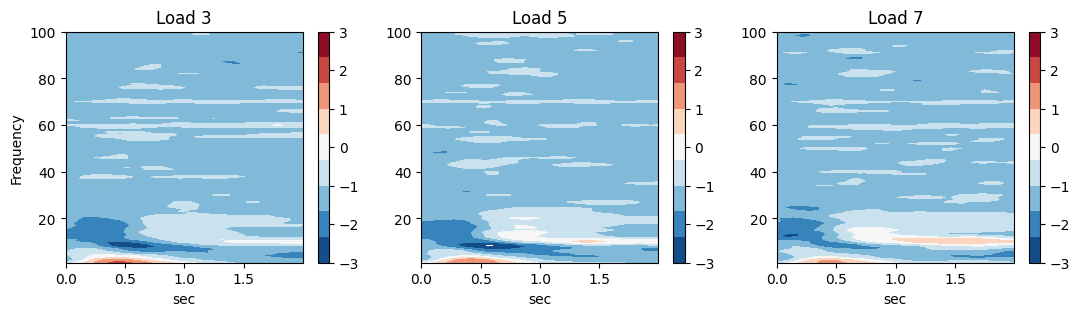

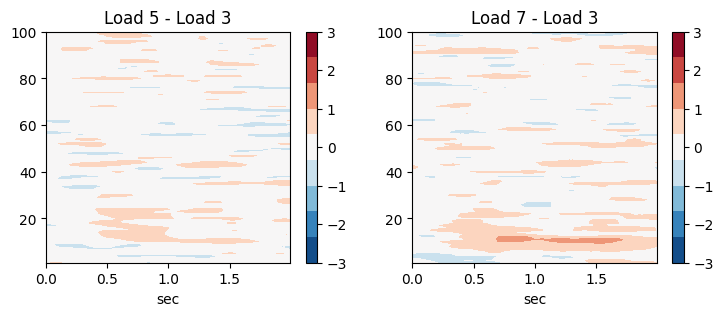

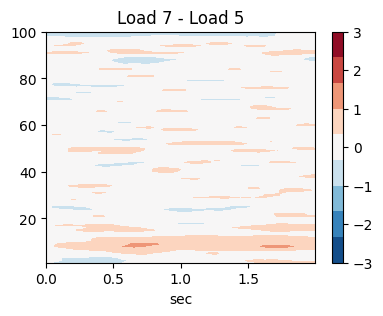

In [2326]:
# TF Visually check
mean_tfpath = 'C:/Users/beene/python/ml_term_export/mean_tf/'
frex = jnp.arange(1, 100.1, 1)
def mean_tf_load(num):
     tf = pickle.load(open(mean_tfpath+f'mean_pow_{num}.pkl', 'rb'))
     """infidx = tf==-np.inf
     if np.sum(infidx):
          infidx1, infidx2 = np.argwhere(tf==-np.inf), np.argwhere(tf==-np.inf)
          infidx1[:, 2] -= np.ones(infidx1.shape[0], dtype = int)
          infidx2[:, 2] += np.ones(infidx2.shape[0], dtype = int)
          tf = tf.at[tf==-np.inf].set((tf[infidx1[:, 0], infidx1[:, 1], infidx1[:, 2]] + tf[infidx2[:, 0], infidx2[:, 1], infidx2[:, 2]])/2)"""
     tf_ga = tf.mean(axis=0)
     return(tf, tf_ga)
     
tf3, tf3_ga = mean_tf_load(0)
tf5, tf5_ga = mean_tf_load(1)
tf7, tf7_ga = mean_tf_load(2)

levels = np.linspace(-3, 3, 10)
plt.figure(figsize = (13, 3))
plt.subplot(1, 3, 1)
ftp = plt.contourf(treamed, frex, tf3_ga, cmap = 'RdBu_r', vmin = -3, vmax = 3, levels=levels)
plt.ylabel('Frequency')
plt.xlabel('sec')
plt.colorbar(ticks = np.arange(-3, 3.1, 1))
plt.clim(-3, 3)
plt.title('Load 3')

plt.subplot(1, 3, 2)
plt.contourf(treamed, frex, tf5_ga, cmap = 'RdBu_r', vmin = -3, vmax = 3, levels=levels)
plt.xlabel('sec')
plt.colorbar(ticks = np.arange(-3, 3.1, 1))
plt.clim(-3, 3)
plt.title('Load 5')

plt.subplot(1, 3, 3)
plt.contourf(treamed, frex, tf7_ga, cmap = 'RdBu_r', vmin = -3, vmax = 3, levels=levels)
plt.xlabel('sec')
plt.colorbar(ticks = np.arange(-3, 3.1, 1))
plt.clim(-3, 3)
plt.title('Load 7')

plt.figure(2, figsize = (13/3*2, 3))
plt.subplot(1, 2, 1)
plt.contourf(treamed, frex, tf5_ga-tf3_ga, cmap = 'RdBu_r', vmin = -3, vmax = 3, levels=levels)
plt.xlabel('sec')
plt.colorbar(ticks = np.arange(-3, 3.1, 1))
plt.clim(-3, 3)
plt.title('Load 5 - Load 3')

plt.subplot(1, 2, 2)
plt.contourf(treamed, frex, tf7_ga-tf3_ga, cmap = 'RdBu_r', vmin = -3, vmax = 3, levels=levels)
plt.xlabel('sec')
plt.colorbar(ticks = np.arange(-3, 3.1, 1))
plt.clim(-3, 3)
plt.title('Load 7 - Load 3')

plt.figure(3, figsize = (13/3, 3))
plt.contourf(treamed, frex, tf7_ga-tf5_ga, cmap = 'RdBu_r', vmin = -3, vmax = 3, levels=levels)
plt.xlabel('sec')
plt.colorbar(ticks = np.arange(-3, 3.1, 1))
plt.clim(-3, 3)
plt.title('Load 7 - Load 5')

Text(0.5, 1.0, 'Load 7')

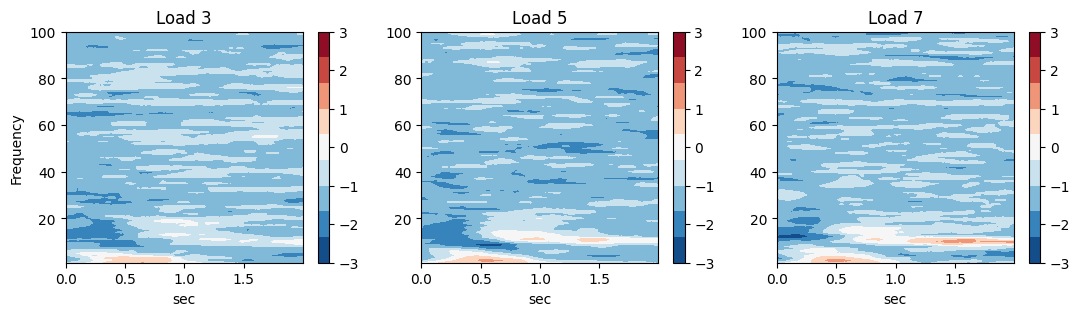

In [2338]:
plt.figure(figsize = (13, 3))
plt.subplot(1, 3, 1)
maxn = 3
levels = np.linspace(-maxn, maxn, 10)
ftp = plt.contourf(treamed, frex, tf3[target_ch].reshape(100, 500), cmap = 'RdBu_r', vmin = -maxn, vmax = maxn, levels = levels)
plt.ylabel('Frequency')
plt.xlabel('sec')
plt.colorbar(ticks = np.arange(-maxn, maxn+0.1, 1))
plt.clim(-3, 3)
plt.title('Load 3')

plt.subplot(1, 3, 2)
plt.contourf(treamed, frex, tf5[target_ch].reshape(100, 500), cmap = 'RdBu_r', vmin = -maxn, vmax = maxn, levels = levels)
plt.xlabel('sec')
plt.colorbar(ticks = np.arange(-maxn, maxn+.1, 1))
plt.clim(-3, 3)
plt.title('Load 5')

plt.subplot(1, 3, 3)
plt.contourf(treamed, frex, tf7[target_ch].reshape(100, 500), cmap = 'RdBu_r', vmin = -maxn, vmax = maxn, levels = levels)
plt.xlabel('sec')
plt.colorbar(ticks = np.arange(-maxn, maxn+0.1, 1))
plt.clim(-3, 3)
plt.title('Load 7')

## Training

In [2]:
# Channel Selection
#chunkpath = 'C:/Users/hyeok/내 드라이브/Python/Machine learning term project/'
chunkpath = 'C:/Users/beene/내 드라이브/Python/Machine learning term project/'
raw = mne.io.read_raw_fif(chunkpath+'sub_0.fif', preload = True)
easycap_montage = mne.channels.make_standard_montage("easycap-M1")

chlist = ['AF3', 'Oz']
target_ch = np.array(np.argwhere([[re.match(x+'$', i) for i in raw.ch_names] for x in chlist]))[:, 1]

Opening raw data file C:/Users/beene/내 드라이브/Python/Machine learning term project/sub_0.fif...
    Range : 0 ... 163237 =      0.000 ...   652.948 secs
Ready.
Reading 0 ... 163237  =      0.000 ...   652.948 secs...


C:\Users\beene\AppData\Local\Temp\ipykernel_20120\4279899827.py:4: RuntimeWarning: This filename (C:/Users/beene/내 드라이브/Python/Machine learning term project/sub_0.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(chunkpath+'sub_0.fif', preload = True)


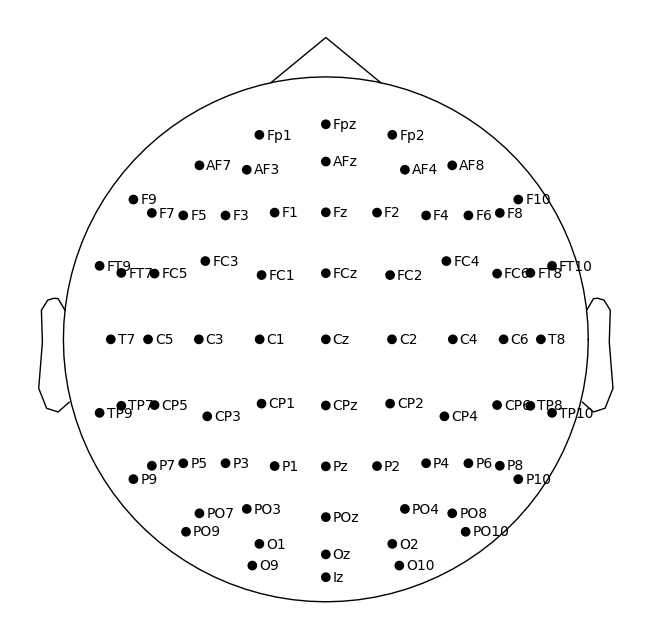

(<Figure size 640x640 with 1 Axes>, None)

In [6]:
easycap_montage.plot(), plt.show()

In [3]:
# Libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

### Time-freuqnecy

In [20]:
# load tf
#tfpath = 'C:/Users/beene/python/ml_term_export/tf_sep_ch/'
#tfpath = 'C:/Users/hyeok/내 드라이브/Python/Machine learning term project/tf/'
tfpath = 'C:/Users/beene/python/ml_term_export/tf/'
#tfpath = 'C:/Users/beene/내 드라이브/Python/Machine learning term project/tf/'
def tf_load(num):
     #split = jnp.array([jnp.abs(treamed-x).argmin() for x in [0.5, 1, 1.5]])
     tf = pickle.load(open(tfpath+f'pow_{num}.pkl', 'rb'))
     """infidx = tf==-np.inf
     if np.sum(infidx):
          infidx1, infidx2 = np.argwhere(tf==-np.inf), np.argwhere(tf==-np.inf)
          infidx1[:, 3] -= np.ones(infidx1.shape[0], dtype = int)
          infidx2[:, 3] += np.ones(infidx2.shape[0], dtype = int)
          tf = tf.at[tf==-np.inf].set((tf[infidx1[:, 0], infidx1[:, 1], infidx1[:, 2],infidx1[:, 3]] + tf[infidx2[:, 0], infidx2[:, 1], infidx2[:, 2],infidx1[:, 3]])/2)"""
     return tf
     
tf3 = tf_load(0)[:, :, :, downsample].mean(axis=1)
tf5 = tf_load(1)[:, :, :, downsample].mean(axis=1)
tf7 = tf_load(2)[:, :, :, downsample].mean(axis=1)

In [2480]:
tf3 = np.array([tf3[:, :, :40].mean(axis = 2), tf3[:, :, 40:].mean(axis = 2)]).transpose(1, 2, 0).reshape(tf3.shape[0], -1)
tf5 = np.array([tf5[:, :, :40].mean(axis = 2), tf5[:, :, 40:].mean(axis = 2)]).transpose(1, 2, 0).reshape(tf5.shape[0], -1)
tf7 = np.array([tf7[:, :, :40].mean(axis = 2), tf7[:, :, 40:].mean(axis = 2)]).transpose(1, 2, 0).reshape(tf7.shape[0], -1)

In [21]:
tf3.shape

(550, 20, 80)

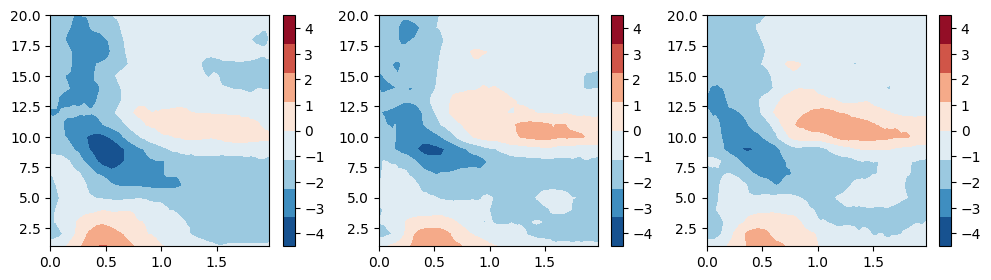

In [2473]:
plt.figure(figsize = (12, 3))
maxn = 4.5
levels = np.linspace(-maxn, maxn, 9)
plt.subplot(1, 3, 1)
plt.contourf(downsampled_times, frex[:20], tf3.mean(axis=0), cmap = 'RdBu_r',
             vmin = -maxn, vmax = maxn, levels = levels)
plt.colorbar(ticks = np.arange(-4, 4+.1, 1))
plt.subplot(1, 3, 2)
plt.contourf(downsampled_times, frex[:20], tf5.mean(axis=0), cmap = 'RdBu_r',
             vmin = -maxn, vmax = maxn, levels = levels)
plt.colorbar(ticks = np.arange(-4, 4+.1, 1))
plt.subplot(1, 3, 3)
plt.contourf(downsampled_times, frex[:20], tf7.mean(axis=0), cmap = 'RdBu_r',
             vmin = -maxn, vmax = maxn, levels = levels)
plt.colorbar(ticks = np.arange(-4, 4+.1, 1))
#plt.axis(aspect = 'image')

In [8]:
# Train-test split
def split_tf(tf3, tf5, tf7):
    #reshapef = lambda x: x[:, chx, :, :40].reshape(x.shape[0], -1)
    all_data = jnp.concatenate((tf3, tf5, tf7))
    all_data = all_data[delmask(all_data)]
    all_data = StandardScaler().fit_transform(all_data) # Standardization
    #all_data = MinMaxScaler().fit_transform(all_data)
    
    all_label = jnp.array([0]*tf3.shape[0]+[1]*tf5.shape[0]+[2]*tf7.shape[0])
    all_label = all_label[delmask(all_data)]

    return train_test_split(all_data, all_label, test_size = 0.2, random_state=10,
                            stratify = all_label, shuffle = True)

def delmask(all_data):
    mask = np.ones((all_data.shape[0], 1), dtype = bool).reshape(-1)
    mask[np.unique(np.argwhere(all_data==-np.inf)[:, 0])] = 0
    maskidx = np.arange(all_data.shape[0])[mask]
    return maskidx

In [9]:
def train_tf(X_train, X_test, y_train, y_test):
    svc = SVC(random_state = 10, kernel = 'rbf', C = 10, degree= 3, gamma = 1, max_iter= -1, probability= True)
    svc_score = cross_val_score(svc, X_train, y_train, cv=5)
    svc.fit(X_train, y_train)
    print(f'SVC score: {svc_score}, {np.mean(svc_score)}'
          f'\npredict score: {accuracy_score(y_test, svc.predict(X_test))}'
          f'\nlabel: {np.unique(svc.predict(X_test))}'
          f'\nprobabilities: {svc.predict_proba(X_test)[:10]}')

    rf = RandomForestClassifier(random_state = 10, n_estimators= 10, max_depth = 5, max_features= 'log2')
    rf_score = cross_val_score(rf, X_train, y_train, cv=5)
    rf.fit(X_train, y_train)
    print(f'random forest score: {rf_score}, {np.mean(rf_score)}'
          f'\npredict score: {accuracy_score(y_test, rf.predict(X_test))}')

    sgdc = SGDClassifier(random_state = 10, loss = 'hinge', penalty= 'l2', alpha= 0.0001)
    sgdc_score = cross_val_score(sgdc, X_train, y_train, cv=5)
    sgdc.fit(X_train, y_train)
    print(f'SGD Classifier score: {sgdc_score}, {np.mean(sgdc_score)}'
          f'\npredict score: {accuracy_score(y_test, sgdc.predict(X_test))}')

    knn = KNeighborsClassifier(n_neighbors = 5, leaf_size= 30)
    knn_score = cross_val_score(knn, X_train, y_train, cv=5)
    knn.fit(X_train, y_train)
    print(f'KNN Classifier score: {knn_score}, {np.mean(knn_score)}'
          f'\npredict score: {accuracy_score(y_test, knn.predict(X_test))}')          


"""for chx in range(len(target_ch)):
      print(f'-------------------------{raw.ch_names[target_ch[chx]]}------------------------')
      train_tf(*split_tf(tf3, tf5, tf7, chx))"""
train_tf(*split_tf(tf3, tf5, tf7))
#train_tf(*split_tf(tf3, tf5, tf7))

ValueError: Found array with dim 3. StandardScaler expected <= 2.

In [23]:
X_train, X_test, y_train, y_test = split_tf(tf3.reshape(tf3.shape[0], -1), tf5.reshape(tf5.shape[0], -1), tf7.reshape(tf7.shape[0], -1))

svc = SVC(random_state = 10)
params = {
    'C': [0.1, 1, 5, 10],
    'kernel': ['rbf'],
    'gamma': [0.1, 1, 5, 10]
}
rm_search = GridSearchCV(
    estimator = svc, 
    param_grid = params
)
rm_search.fit(X_train, y_train)
best_params = rm_search.best_params_
best_model = rm_search.best_estimator_

y_pred_best = best_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Best SVC Accuracy: {accuracy_best:.2f}")
print(f"Best Hyperparameters: {best_params}")

Best SVC Accuracy: 0.34
Best Hyperparameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}


In [2383]:
y_pred_best = best_model.predict(X_test)
prec, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_best, labels =[0, 1, 2] ,average = None)
print(f"Best SVC prec: {prec:.2f}\n"
      f"Best SVC recall: {recall:.2f}\n"
      f"Best SVC f1: {f1:.2f}\n")

c:\Users\beene\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TypeError: unsupported format string passed to numpy.ndarray.__format__

In [2371]:
rf = RandomForestClassifier()
params2 = {
    'n_estimators': [10, 30, 70, 100],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [2, 10, 30, 50, 100],
    'max_features': ['sqrt', 'log2'],
    'oob_score': [True]
}
rm_search2 = RandomizedSearchCV(
    estimator = rf, 
    param_distributions = params2,
    random_state = 10
)
rm_search2.fit(X_train, y_train)
best_params2 = rm_search2.best_params_
best_model2 = rm_search2.best_estimator_

y_pred_best = best_model2.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Best SVC Accuracy: {accuracy_best:.2f}")
print(f"Best Hyperparameters: {best_params2}")

c:\Users\beene\anaconda3\envs\torch\lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\beene\anaconda3\envs\torch\lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\beene\anaconda3\envs\torch\lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\beene\anaconda3\envs\torch\lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\beene\anaconda3\envs\torch\lib\site-packages\sklearn\ensemble\_forest.py:578: UserW

Best SVC Accuracy: 0.34
Best Hyperparameters: {'oob_score': True, 'n_estimators': 100, 'max_features': 'log2', 'max_depth': 100, 'criterion': 'entropy'}


### Power Spectrum

In [2537]:
# load psd
psdpath = 'C:/Users/beene/python/ml_term_export/psd/'
#psdpath = 'C:/Users/beene/내 드라이브/Python/Machine learning term project/psd/'
#psdpath = 'C:/Users/hyeok/내 드라이브/Python/Machine learning term project/psd/'
psd3 = jnp.array(pickle.load(open(psdpath+'psd_0.pkl', 'rb')))
psd5 = jnp.array(pickle.load(open(psdpath+'psd_1.pkl', 'rb')))
psd7 = jnp.array(pickle.load(open(psdpath+'psd_2.pkl', 'rb')))


"""psd3 = psd3[:, :, np.arange(8, 13.1, 1, dtype = int)].max(axis=2)[:, target_ch[1]]
psd5 = psd5[:, :, np.arange(8, 13.1, 1, dtype = int)].max(axis=2)[:, target_ch[1]]
psd7 = psd7[:, :, np.arange(8, 13.1, 1, dtype = int)].max(axis=2)[:, target_ch[1]]"""

"""psd3 = psd3[:, target_ch[0], :20]
psd5 = psd5[:, target_ch[0], :20]
psd7 = psd7[:, target_ch[0], :20]"""

'psd3 = psd3[:, target_ch[0], :20]\npsd5 = psd5[:, target_ch[0], :20]\npsd7 = psd7[:, target_ch[0], :20]'

Text(0.5, 1.0, 'Oz')

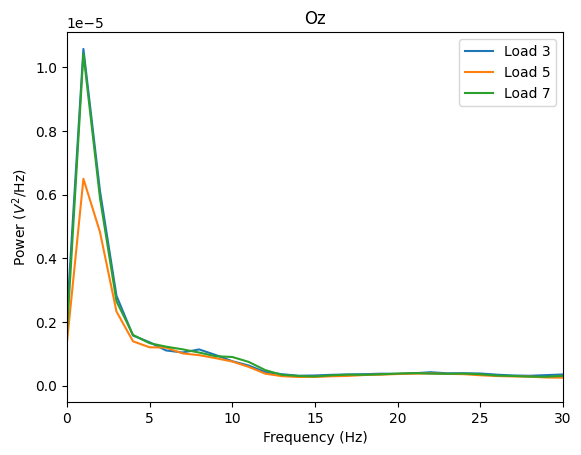

In [2540]:
plt.plot(psd3.mean(0)[target_ch[0]]), plt.plot(psd5.mean(0)[target_ch[0]]), plt.plot(psd7.mean(0)[target_ch[0]])
plt.xlim(0, 30)
plt.legend(['Load 3', 'Load 5', 'Load 7'])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power ($V^2$/Hz)')
plt.title('Oz')

In [ ]:
for fig_i in range(psd3.shape[1]):
    plt.figure(figsize=(5, 5))
    plt.plot(psd3.mean(axis=0)[fig_i, :])
    plt.plot(psd5.mean(axis=0)[fig_i, :])
    plt.plot(psd7.mean(axis=0)[fig_i, :])
    plt.title(raw.ch_names[fig_i])
    plt.show()

In [2531]:
# Train-test split
all_data = jnp.concatenate((psd3[:, target_ch[1], :13], psd5[:, target_ch[1], :13], psd7[:, target_ch[1], :13]))
all_label = jnp.array([0]*psd3.shape[0]+[1]*psd5.shape[0]+[2]*psd7.shape[0])
all_data = StandardScaler().fit_transform(all_data) # Standardization
#all_data = MinMaxScaler().fit_transform(all_data) # Standardization

X_train, X_test, y_train, y_test = train_test_split(all_data, all_label, test_size = 0.2, random_state=10,
                                                    stratify = all_label, shuffle = True)

In [2528]:
all_data.shape

(1611, 13)

In [2532]:
def train_psd(X_train, X_test, y_train, y_test):
    svc = SVC(random_state = 10, kernel = 'rbf', C = 100, degree= 3, gamma = 1, max_iter= -1, probability=True)
    svc_score = cross_val_score(svc, X_train, y_train, cv=5)
    svc.fit(X_train, y_train)
    print(f'SVC score: {svc_score}'
          f'\npredict score: {accuracy_score(y_test, svc.predict(X_test))}'
          f'\nprobability: {svc.predict_proba(X_test)[:10]}')

    rf = RandomForestClassifier(random_state = 10, n_estimators= 10, max_depth = 5, max_features= 'log2')
    rf_score = cross_val_score(rf, X_train, y_train, cv=5)
    rf.fit(X_train, y_train)
    print(f'random forest score: {rf_score}'
          f'\npredict score: {accuracy_score(y_test, rf.predict(X_test))}')

    sgdc = SGDClassifier(random_state = 10, loss = 'hinge', penalty= 'l2', alpha= 0.0001)
    sgdc_score = cross_val_score(sgdc, X_train, y_train, cv=5)
    sgdc.fit(X_train, y_train)
    print(f'SGD Classifier score: {sgdc_score}'
          f'\npredict score: {accuracy_score(y_test, sgdc.predict(X_test))}')

train_psd(X_train, X_test, y_train, y_test)

SVC score: [0.40310078 0.31007752 0.33333333 0.32684825 0.37354086]
predict score: 0.34365325077399383
probability: [[0.33385435 0.32699702 0.33914862]
 [0.34501859 0.32654425 0.32843716]
 [0.34901795 0.33008991 0.32089214]
 [0.33081978 0.32970039 0.33947984]
 [0.36981745 0.33204874 0.29813382]
 [0.32258785 0.32125456 0.3561576 ]
 [0.32346326 0.33101544 0.3455213 ]
 [0.34362556 0.32627839 0.33009605]
 [0.34112551 0.30118238 0.35769211]
 [0.33036231 0.31867021 0.35096748]]
random forest score: [0.35658915 0.34496124 0.34108527 0.28015564 0.42412451]
predict score: 0.34055727554179566
SGD Classifier score: [0.36046512 0.36821705 0.28682171 0.3229572  0.3463035 ]
predict score: 0.3591331269349845


In [2533]:
np.mean([0.40310078, 0.31007752, 0.33333333, 0.32684825, 0.37354086])

0.349380148

In [54]:
svc = SVC(random_state = 10)
params = {
    'C': [0.1, 1, 5, 10],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': [0.1, 1, 5, 10, 'scale', 'auto']
}
rm_search = GridSearchCV(
    estimator = svc, 
    param_grid = params,
)
rm_search.fit(X_train, y_train)
best_params = rm_search.best_params_
best_model = rm_search.best_estimator_

y_pred_best = best_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Best SVC Accuracy: {accuracy_best:.2f}")
print(f"Best Hyperparameters: {best_params}")

In [47]:
from __future__ import print_function
from sys import getsizeof, stderr
from itertools import chain
from collections import deque
try:
    from reprlib import repr
except ImportError:
    pass

def total_size(o, handlers={}, verbose=False):
    """ Returns the approximate memory footprint an object and all of its contents.

    Automatically finds the contents of the following builtin containers and
    their subclasses:  tuple, list, deque, dict, set and frozenset.
    To search other containers, add handlers to iterate over their contents:

        handlers = {SomeContainerClass: iter,
                    OtherContainerClass: OtherContainerClass.get_elements}

    """
    dict_handler = lambda d: chain.from_iterable(d.items())
    all_handlers = {tuple: iter,
                    list: iter,
                    deque: iter,
                    dict: dict_handler,
                    set: iter,
                    frozenset: iter,
                   }
    all_handlers.update(handlers)     # user handlers take precedence
    seen = set()                      # track which object id's have already been seen
    default_size = getsizeof(0)       # estimate sizeof object without __sizeof__

    def sizeof(o):
        if id(o) in seen:       # do not double count the same object
            return 0
        seen.add(id(o))
        s = getsizeof(o, default_size)

        if verbose:
            print(s, type(o), repr(o), file=stderr)

        for typ, handler in all_handlers.items():
            if isinstance(o, typ):
                s += sum(map(sizeof, handler(o)))
                break
        return s

    return sizeof(o)


##### Example call #####

if __name__ == '__main__':
    d = dict(a=1, b=2, c=3, d=[4,5,6,7], e='a string of chars')
    print(total_size(np.array(wl), verbose=True))

161054096


161054096 <class 'numpy.ndarray'> array([6.2194...ype=complex64)
